In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import (
    Conv2D, 
    Dense, 
    BatchNormalization, 
    Activation, 
    MaxPool2D, 
    GlobalAveragePooling2D, 
    Add, 
    Input, 
    Flatten, 
    LeakyReLU, 
    Concatenate, 
    Dropout,
    MaxPooling2D
)
from tensorflow.keras import Model, Sequential
from tensorflow.keras.constraints import Constraint ,UnitNorm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Orthogonal
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from io import StringIO
import emnist as em
import re
import os

### Helper methods

Data augmentation

## ResNet

In [ ]:
# https://arxiv.org/pdf/1512.03385.pdf

In [11]:
def create_resnet(input_shape, class_count):
    n = 9 # 56 layers
    channels = [16, 32, 64]

    inputs = Input(shape=input_shape)
    x = Conv2D(channels[0], kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)

    for c in channels:
        for i in range(n):
            subsampling = i == 0 and c > 16
            strides = (2, 2) if subsampling else (1, 1)
            y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
            y = BatchNormalization()(y)
            y = Activation(tf.nn.relu)(y)
            y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
            y = BatchNormalization()(y)        
            if subsampling:
                x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
            x = Add()([x, y])
            x = Activation(tf.nn.relu)(x)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(class_count, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

    return Model(inputs=inputs, outputs=outputs)

In [12]:
# PREPARE TRAINING
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9)
import time


class LearningController(Callback):
    def __init__(self, num_epoch=0, learn_minute=0):
        self.num_epoch = num_epoch
        self.learn_second = learn_minute * 60
        if self.learn_second > 0:
            print("Leraning rate is controled by time.")
        elif self.num_epoch > 0:
            print("Leraning rate is controled by epoch.")
        
    def on_train_begin(self, logs=None):
        if self.learn_second > 0:
            self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if self.learn_second > 0:
            current_time = time.time()
            if current_time - self.start_time > self.learn_second / 2:
                self.model.optimizer.lr = lr * 0.1            
            if current_time - self.start_time > self.learn_second * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                
        elif self.num_epoch > 0:
            if epoch > self.num_epoch / 2:
                self.model.optimizer.lr = lr * 0.1            
            if epoch > self.num_epoch * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                    
        print('lr:%.2e' % self.model.optimizer.lr.value())
        

learn_minute = 120

## Dense NN

In [2]:
def create_dense_nn(input_shape):
    return Sequential(
        [
            Input(shape=input_shape),
            Flatten(),
            Dense(64),
        ],
    )

In [3]:
batch_size = 128
num_epoch = 128

## CIFAR-10

In [4]:
cifar = tfds.load('cifar10', as_supervised = True, batch_size = -1)
cifar_test, cifar_train = cifar['test'], cifar['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteYP5SBQ/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteYP5SBQ/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
cifar_train_x = cifar_train[0].numpy() / 255
cifar_train_y = cifar_train[1].numpy()
cifar_test_x = cifar_test[0].numpy() / 255
cifar_test_y = cifar_test[1].numpy()

In [6]:
cifar_train_x, cifar_val_x, cifar_train_y, cifar_val_y = train_test_split(cifar_train_x, cifar_train_y, 
    test_size=0.25, random_state= 8)

## Teacher 

In [13]:
cifar_teacher_model = create_resnet((32, 32, 3), 10)
cifar_teacher_model.type = "cifar_resnet"
cifar_teacher_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [14]:
cifar_teacher_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cifar_teacher_path = "ResNet-for-CIFAR-10.h5"
cifar_teacher_checkpoint = ModelCheckpoint(filepath = cifar_teacher_path, monitor="val_loss", verbose=1, save_best_only=True)
cifar_teacher_learning_controller = LearningController(num_epoch)
cifar_teacher_callbacks = [cifar_teacher_checkpoint, cifar_teacher_learning_controller]

Leraning rate is controled by epoch.


Epoch 1/128
293/293 [==============================] - ETA: 0s - loss: 3.4885 - accuracy: 0.1093
Epoch 1: val_loss improved from inf to 3.22650, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 41s 89ms/step - loss: 3.4885 - accuracy: 0.1093 - val_loss: 3.2265 - val_accuracy: 0.1278
Epoch 2/128
293/293 [==============================] - ETA: 0s - loss: 2.9530 - accuracy: 0.1724
Epoch 2: val_loss improved from 3.22650 to 3.07723, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 25s 84ms/step - loss: 2.9530 - accuracy: 0.1724 - val_loss: 3.0772 - val_accuracy: 0.1371
Epoch 3/128
293/293 [==============================] - ETA: 0s - loss: 2.5732 - accuracy: 0.2990
Epoch 3: val_loss improved from 3.07723 to 2.54539, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 25s 85ms/step - loss: 2.5732 - accuracy: 0.2990 - val_loss: 2.5454 - val_accuracy: 0.3011
Epoch

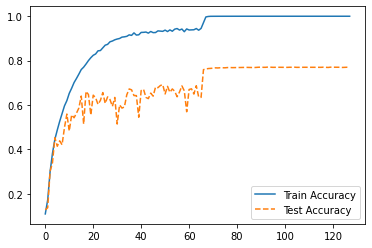

In [15]:
# TRAIN

if os.path.isfile(cifar_teacher_path):
    cifar_teacher_model.load_weights(cifar_teacher_path)
else:
    cifar_history = cifar_teacher_model.fit(cifar_train_x, cifar_train_y,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    validation_data=(cifar_val_x, cifar_val_y), 
                    verbose=1,                    
                    callbacks=cifar_teacher_callbacks)

    plt.plot(cifar_history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(cifar_history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
    plt.legend()
    plt.show()

In [16]:
cifar_teacher_model.evaluate(cifar_test_x, cifar_test_y)

313/313 [==============================] - 3s 10ms/step - loss: 1.5797 - accuracy: 0.7594


[1.579697608947754, 0.7594000101089478]

### Reduced Teacher

In [17]:
cifar_reduced_teacher = create_dense_nn((32, 32, 3))
cifar_reduced_teacher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                196672    
                                                                 
Total params: 196,672
Trainable params: 196,672
Non-trainable params: 0
_________________________________________________________________


## EMINIST

In [18]:
(emnist_train_x, emnist_train_y) = em.extract_training_samples('letters')
emnist_train_x, emnist_train_y = shuffle(emnist_train_x, emnist_train_y)
(emnist_test_x, emnist_test_y) = em.extract_test_samples('letters')
emnist_train_x = emnist_train_x.reshape((emnist_train_x.shape[0], 28, 28, 1))
emnist_test_x = emnist_test_x.reshape((emnist_test_x.shape[0], 28, 28, 1))

In [19]:
emnist_train_x = emnist_train_x.astype('float32')
emnist_test_x = emnist_test_x.astype('float32')
emnist_train_x = emnist_train_x / 255.0
emnist_test_x = emnist_test_x / 255.0

emnist_train_x, emnist_val_x, emnist_train_y, emnist_val_y = train_test_split(emnist_train_x, emnist_train_y, 
    test_size=0.25, random_state= 8)

### Teacher 

In [20]:
emnist_teacher_model = create_resnet((28, 28, 1), 27)
emnist_teacher_model.type = "emnist_resnet"

In [21]:
emnist_teacher_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

emnist_teacher_path = "ResNet-for-EMNIST.h5"
emnist_teacher_checkpoint = ModelCheckpoint(filepath = emnist_teacher_path, monitor="val_loss", verbose=1, save_best_only=True)
emnist_teacher_learning_controller = LearningController(num_epoch)
emnist_teacher_callbacks = [emnist_teacher_checkpoint, emnist_teacher_learning_controller]

Leraning rate is controled by epoch.


Epoch 1/64
732/732 [==============================] - ETA: 0s - loss: 2.2408 - accuracy: 0.5252
Epoch 1: val_loss improved from inf to 1.16779, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 58s 70ms/step - loss: 2.2408 - accuracy: 0.5252 - val_loss: 1.1678 - val_accuracy: 0.7674
Epoch 2/64
731/732 [============================>.] - ETA: 0s - loss: 0.8921 - accuracy: 0.8588
Epoch 2: val_loss improved from 1.16779 to 0.83724, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 52s 71ms/step - loss: 0.8920 - accuracy: 0.8588 - val_loss: 0.8372 - val_accuracy: 0.8717
Epoch 3/64
731/732 [============================>.] - ETA: 0s - loss: 0.7415 - accuracy: 0.8995
Epoch 3: val_loss improved from 0.83724 to 0.75588, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 51s 69ms/step - loss: 0.7415 - accuracy: 0.8995 - val_loss: 0.7559 - val_accuracy: 0.8920
Epoch 4/64
731

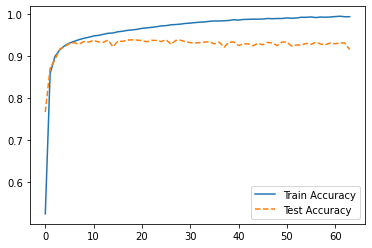

In [22]:
# TRAIN

if os.path.isfile(emnist_teacher_path):
    emnist_teacher_model.load_weights(cifar_teacher_path)
else:
    emnist_history = emnist_teacher_model.fit(emnist_train_x, emnist_train_y, 
                    epochs=64, 
                    batch_size=batch_size, 
                    validation_data=(emnist_val_x, emnist_val_y), 
                    callbacks=emnist_teacher_callbacks,
          )


    plt.plot(emnist_history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(emnist_history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
    plt.legend()
    plt.show()

In [23]:
emnist_teacher_model.evaluate(emnist_test_x, emnist_test_y)

650/650 [==============================] - 6s 10ms/step - loss: 0.7613 - accuracy: 0.9120


[0.7612522840499878, 0.9120192527770996]

### Reduced Teacher 

In [24]:
emnist_reduced_teacher = create_dense_nn((28, 28, 1))
emnist_reduced_teacher.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________
